# Llibreries

In [2]:
# Import llibreries

import json
import os
import sys
import time
import datetime
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Cas Previ 

In [3]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(os.getcwd(), carpeta_dades, fitxer_dades)


    # Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

    # Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

#     # Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'])

df.head()


,data,valor
0,1998-01-01 00:00:00+00:00,-4.6
1,1998-01-01 01:00:00+00:00,-5.1
2,1998-01-01 02:00:00+00:00,-5.3
3,1998-01-01 03:00:00+00:00,-5.5
4,1998-01-01 04:00:00+00:00,-5.8


In [4]:
# Agafar només les dades corresponents als hiverns i posar-les en un nou dataframe
# Les dates dels hiverns seran del 1 de desembre al 31 de març
df_hiverns = df[(df['data'].dt.month >= 11) | (df['data'].dt.month <= 2)]

df_hiverns.head()

,data,valor
0,1998-01-01 00:00:00+00:00,-4.6
1,1998-01-01 01:00:00+00:00,-5.1
2,1998-01-01 02:00:00+00:00,-5.3
3,1998-01-01 03:00:00+00:00,-5.5
4,1998-01-01 04:00:00+00:00,-5.8


In [5]:
# Establir llindars de Temperatura per a cada situació discreta
# 1. Temperatura mes baixa de 1 grau dona neu
# 2. Temperatura entre 1 i 2 graus dona aiguaneu
# 3. Temperatura superior a 2 graus dona pluja

# Afegim una columna amb la categoria de precipitació N,A,P


df_hiverns.loc[:, 'precipitacio'] = pd.cut(df_hiverns['valor'], bins=[-np.inf, 1, 2, np.inf], labels=['N', 'A', 'P'])

df_hiverns.head()

/tmp/ipykernel_5290/2899662009.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hiverns.loc[:, 'precipitacio'] = pd.cut(df_hiverns['valor'], bins=[-np.inf, 1, 2, np.inf], labels=['N', 'A', 'P'])


,data,valor,precipitacio
0,1998-01-01 00:00:00+00:00,-4.6,N
1,1998-01-01 01:00:00+00:00,-5.1,N
2,1998-01-01 02:00:00+00:00,-5.3,N
3,1998-01-01 03:00:00+00:00,-5.5,N
4,1998-01-01 04:00:00+00:00,-5.8,N


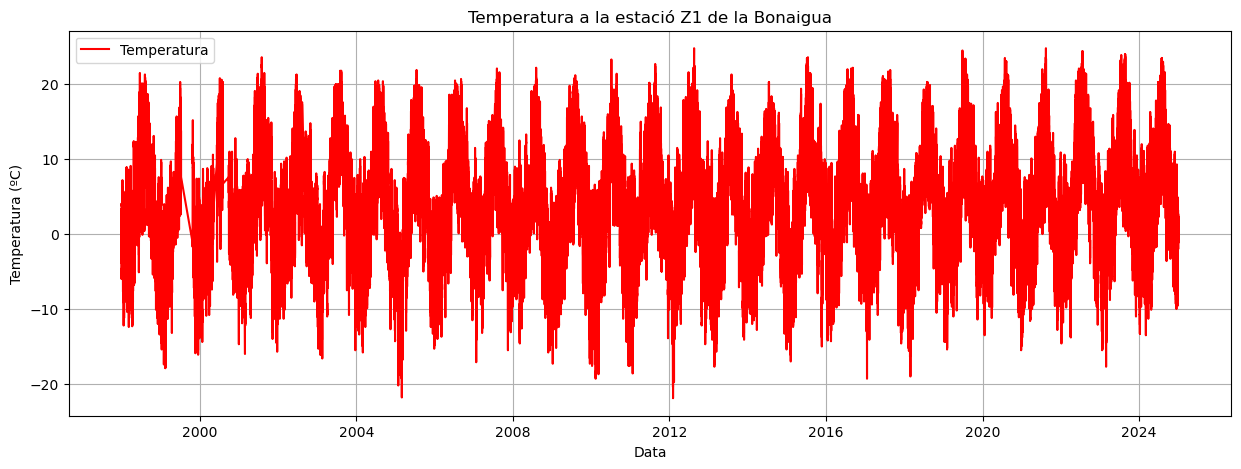

In [6]:
# Graficar la temperatura de les dades de df

plt.figure(figsize=(15, 5))
plt.plot(df['data'], df['valor'], label='Temperatura', color='red')
plt.title('Temperatura a la estació Z1 de la Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


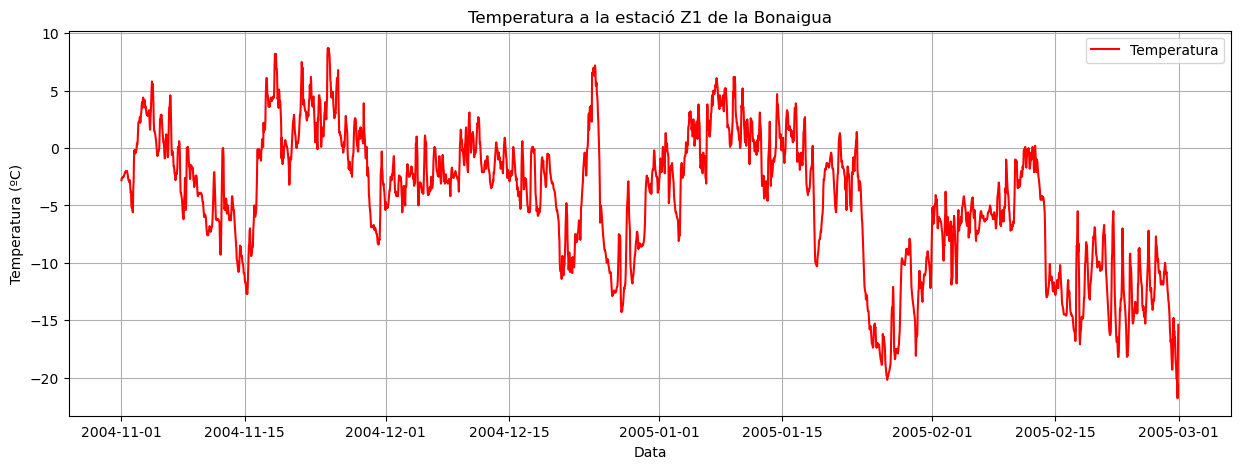

In [7]:
# Filtrar les dades per hivern 2009-2010 (novembre 2009 - febrer 2010)
any = 2005
any_ant = any - 1

df_hiverns_temporda = df_hiverns[
    ((df_hiverns['data'].dt.year == any_ant) & (df_hiverns['data'].dt.month >= 11)) | 
    ((df_hiverns['data'].dt.year == any) & (df_hiverns['data'].dt.month <= 2))
]

# Graficar la temperatura
plt.figure(figsize=(15, 5))
plt.plot(df_hiverns_temporda['data'], df_hiverns_temporda['valor'], label='Temperatura', color='red')
plt.title('Temperatura a la estació Z1 de la Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


In [8]:
# Calcular las probabilitat de cada tipus de precipitació

prob_precipitacio = df_hiverns['precipitacio'].value_counts(normalize=True)

prob_precipitacio

precipitacio
N    0.716349
P    0.221608
A    0.062043
Name: proportion, dtype: float64

In [9]:
# Crear una columna per l'estat anterior de la precipitació
df_hiverns['precipitacio_anterior'] = df_hiverns['precipitacio'].shift(1)

# Eliminar les files amb NaN a la columna 'precipitacio_anterior' (ja que la primera fila no té valor anterior)
df_hiverns = df_hiverns.dropna(subset=['precipitacio_anterior'])

# Calcular les transicions: com passar d'un estat a un altre
transicions = pd.crosstab(df_hiverns['precipitacio_anterior'], df_hiverns['precipitacio'], normalize='index')

/tmp/ipykernel_5290/2663720117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hiverns['precipitacio_anterior'] = df_hiverns['precipitacio'].shift(1)


In [10]:
transicions

precipitacio,N,A,P
precipitacio_anterior,,,
N,0.979160,0.017712,0.003128
A,0.212982,0.592674,0.194344
P,0.007737,0.056785,0.935478


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


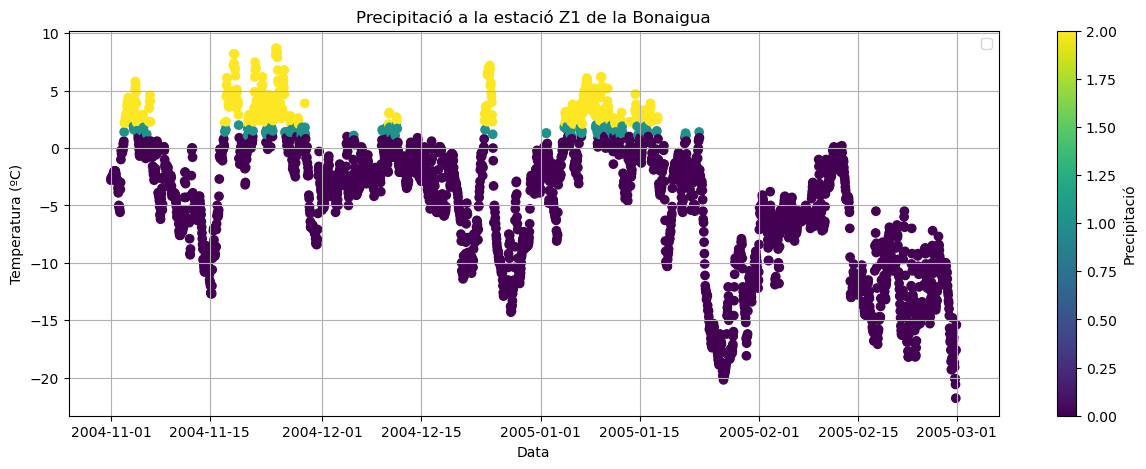

In [11]:
# Graficar les precipitacions en l'hivern 2009-2010

plt.figure(figsize=(15, 5))
# plt.plot(df_hiverns_temporda['data'], df_hiverns_temporda['valor'], label='Temperatura', color='red')

# Codificar la variable de precipitació per a la gràfica i representar-la

df_hiverns_temporda['precipitacio_codificada'] = df_hiverns_temporda['precipitacio'].map({'N': 0, 'A': 1, 'P': 2})

plt.scatter(df_hiverns_temporda['data'], df_hiverns_temporda['valor'], c=df_hiverns_temporda['precipitacio_codificada'], cmap='viridis')


plt.title('Precipitació a la estació Z1 de la Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
# Llegenda de colors de la codificació de la precipitació
plt.colorbar(label='Precipitació')

plt.grid()
plt.show()

In [12]:
# Simular el temps a partir de les probabilitats de transició en la mateuixa temporada

# Definir la durada de la simulació
dies_simul = len(df_hiverns_temporda)

# Definir la primera precipitació de la simulació
precipitacio_t0 = df_hiverns_temporda['precipitacio'].iloc[0]
precipitacio_t1 = df_hiverns_temporda['precipitacio'].iloc[1]

# Crear una llista per guardar les precipitacions simulades
precipitacions_simulades = [precipitacio_t0, precipitacio_t1]

# Simular la precipitació
for i in range(2, dies_simul):
    precipitacio_anterior = precipitacions_simulades[i - 1]
    probabilitats = transicions.loc[precipitacio_anterior]
    precipitacio_simulada = np.random.choice(probabilitats.index, p=probabilitats.values)
    precipitacions_simulades.append(precipitacio_simulada)

    # Afegir les precipitacions simulades al DataFrame
df_hiverns_temporda['precipitacio_simulada'] = precipitacions_simulades

# Codifica la precipitació simulada per a la gràfica
df_hiverns_temporda['precipitacio_simulada_codificada'] = df_hiverns_temporda['precipitacio_simulada'].map({'N': 0, 'A': 1, 'P': 2})

df_hiverns_temporda.head()

,data,valor,precipitacio,precipitacio_codificada,precipitacio_simulada,precipitacio_simulada_codificada
53856,2004-11-01 00:00:00+00:00,-2.8,N,0,N,0
53857,2004-11-01 01:00:00+00:00,-2.6,N,0,N,0
53858,2004-11-01 02:00:00+00:00,-2.6,N,0,N,0
53859,2004-11-01 03:00:00+00:00,-2.6,N,0,N,0
53860,2004-11-01 04:00:00+00:00,-2.5,N,0,N,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


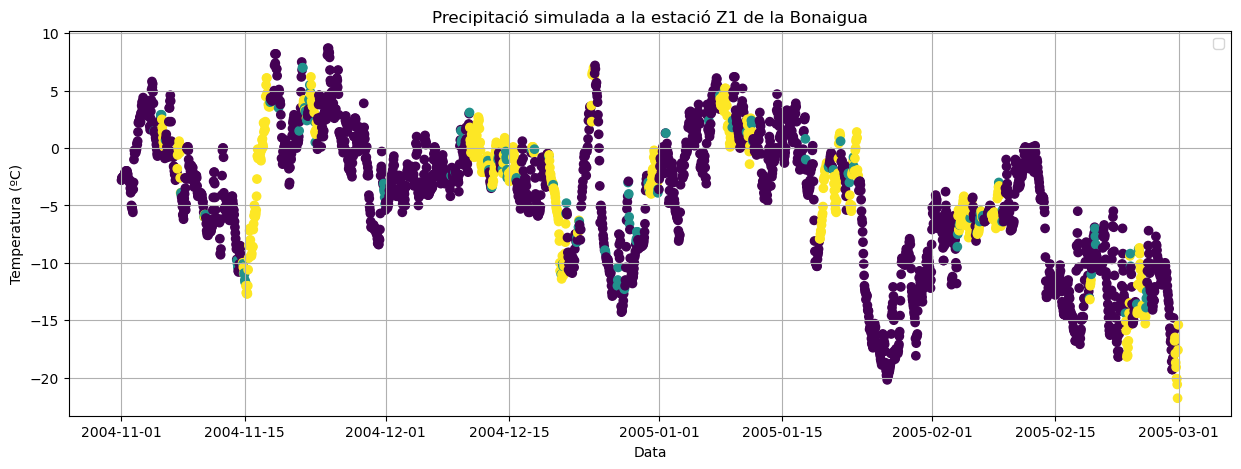

In [13]:
# Graficar les precipitacions simulades en l'hivern 2009-2010 com grafic anterior

plt.figure(figsize=(15, 5))

plt.scatter(df_hiverns_temporda['data'], df_hiverns_temporda['valor'], c=df_hiverns_temporda['precipitacio_simulada_codificada'], cmap='viridis')

plt.title('Precipitació simulada a la estació Z1 de la Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()



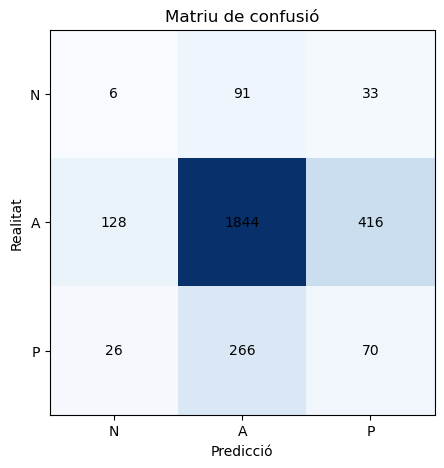

In [14]:
# Plot de la matriu de confusió

conf_matrix = confusion_matrix(df_hiverns_temporda['precipitacio'], df_hiverns_temporda['precipitacio_simulada'])

plt.figure(figsize=(5, 5))
plt.imshow(conf_matrix, cmap='Blues')

plt.xticks([0, 1, 2], ['N', 'A', 'P'])
plt.yticks([0, 1, 2], ['N', 'A', 'P'])

plt.xlabel('Predicció')
plt.ylabel('Realitat')

plt.title('Matriu de confusió')

for i in range(3):
    for j in range(3):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.show()



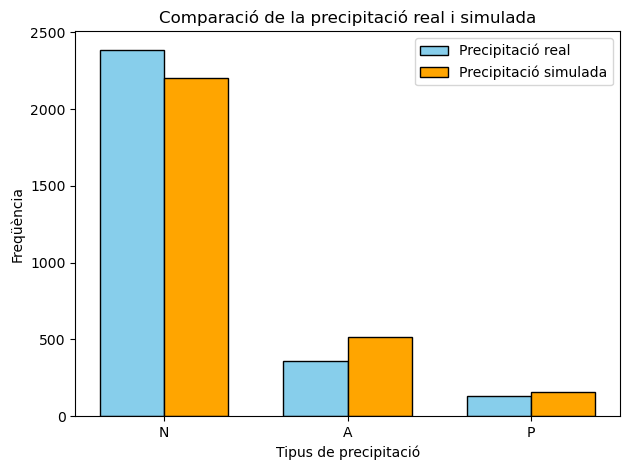

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Suposem que les sèries 'precipitacio' i 'precipitacio_simulada' estan agrupades per les categories "N", "A" i "P"
# A continuació, agrupem les dades per aquestes categories.

categories = df_hiverns_temporda['precipitacio'].unique()
precip_real = df_hiverns_temporda['precipitacio'].value_counts() 
precip_simu = df_hiverns_temporda['precipitacio_simulada'].value_counts()

# Ajustar l'amplada de les barres
width = 0.35

# Crear els índexs per a les categories
indices = np.arange(len(categories))

# Crear el gràfic de barres comparatives
plt.bar(indices - width/2, precip_real, width, label='Precipitació real', color='skyblue', edgecolor='black')
plt.bar(indices + width/2, precip_simu, width, label='Precipitació simulada', color='orange', edgecolor='black')

# Afegir títol i etiquetes
plt.title('Comparació de la precipitació real i simulada')
plt.xlabel('Tipus de precipitació')
plt.ylabel('Freqüència')
plt.xticks(indices, categories)  # Utilitzar les categories "N", "A", "P" com a etiquetes de l'eix X
plt.legend()  # Mostrar la llegenda

# Mostrar el gràfic
plt.tight_layout()  # Per evitar que les etiquetes es tallin
plt.show()

# Segon cas

In [16]:
# Agafem les dades per pronosticar i calcular probabilitats fins la temporada de l'hivern 2014-2015

any = 2015
any_ant = any - 1

df_hiverns_train = df[
    ((df['data'].dt.year == any_ant) & (df['data'].dt.month >= 11)) | 
    ((df['data'].dt.year == any) & (df['data'].dt.month <= 2))
]

df_hiverns_train.head()

,data,valor
196816,2014-11-01 00:00:00+00:00,6.5
196817,2014-11-01 00:30:00+00:00,6.4
196818,2014-11-01 01:00:00+00:00,6.5
196819,2014-11-01 01:30:00+00:00,6.4
196820,2014-11-01 02:00:00+00:00,6.2


In [17]:
# Codifiquem variable Temperatura en 3 categories

df_hiverns_train.loc[:, 'precipitacio'] = pd.cut(df_hiverns_train['valor'], bins=[-np.inf, 1, 2, np.inf], labels=['N', 'A', 'P'])

df_hiverns_train.head()

/tmp/ipykernel_5290/907999380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hiverns_train.loc[:, 'precipitacio'] = pd.cut(df_hiverns_train['valor'], bins=[-np.inf, 1, 2, np.inf], labels=['N', 'A', 'P'])


,data,valor,precipitacio
196816,2014-11-01 00:00:00+00:00,6.5,P
196817,2014-11-01 00:30:00+00:00,6.4,P
196818,2014-11-01 01:00:00+00:00,6.5,P
196819,2014-11-01 01:30:00+00:00,6.4,P
196820,2014-11-01 02:00:00+00:00,6.2,P


In [18]:
# Afegim Columna de precipitació el dia anterior. Assumim en el cas de la primera fila que l'anterior es igual a la mateixa

df_hiverns_train.loc[:, 'precipitacio_anterior'] = df_hiverns_train['precipitacio'].shift(1)

df_hiverns_train = df_hiverns_train.dropna(subset=['precipitacio_anterior'])

df_hiverns_train.head()

/tmp/ipykernel_5290/442808875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hiverns_train.loc[:, 'precipitacio_anterior'] = df_hiverns_train['precipitacio'].shift(1)


,data,valor,precipitacio,precipitacio_anterior
196817,2014-11-01 00:30:00+00:00,6.4,P,P
196818,2014-11-01 01:00:00+00:00,6.5,P,P
196819,2014-11-01 01:30:00+00:00,6.4,P,P
196820,2014-11-01 02:00:00+00:00,6.2,P,P
196821,2014-11-01 02:30:00+00:00,6.2,P,P


In [19]:
# Calcular les probabilitats de transició, es a dir les probabilitats condicionades que faci un estat sabent quin era l'anterior

transicions_prob = pd.crosstab(df_hiverns_train['precipitacio_anterior'], df_hiverns_train['precipitacio'], normalize='index')

transicions_prob


precipitacio,N,A,P
precipitacio_anterior,,,
N,0.987590,0.011282,0.001128
A,0.177852,0.664430,0.157718
P,0.002915,0.048591,0.948494


In [20]:
# Agafem el Dataframe que farem servir de Validació que es a partir de la temporada 2015-2016

any = 2016
any_ant = any - 1

df_hiverns_test = df[
    ((df['data'].dt.year == any_ant) & (df['data'].dt.month >= 11)) | 
    ((df['data'].dt.year == any) & (df['data'].dt.month <= 2))
]


# Codifiquem variable Temperatura en 3 categories

df_hiverns_test.loc[:, 'precipitacio'] = pd.cut(df_hiverns_test['valor'], bins=[-np.inf, 1, 2, np.inf], labels=['N', 'A', 'P'])

df_hiverns_test.head()

/tmp/ipykernel_5290/3032514616.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hiverns_test.loc[:, 'precipitacio'] = pd.cut(df_hiverns_test['valor'], bins=[-np.inf, 1, 2, np.inf], labels=['N', 'A', 'P'])


,data,valor,precipitacio
214336,2015-11-01 00:00:00+00:00,6.4,P
214337,2015-11-01 00:30:00+00:00,5.8,P
214338,2015-11-01 01:00:00+00:00,5.4,P
214339,2015-11-01 01:30:00+00:00,5.1,P
214340,2015-11-01 02:00:00+00:00,5.1,P


In [21]:
# Simulem la precipitació a partir de les probabilitats de transició de l'hivern 2015-2016
# Per fer-ho afegim columna Preciptació simulada. En aquesta afegirem un valor categoric de N A P en base a les probabilitats de transició

dies_simul = len(df_hiverns_test)

# Definir la primera precipitació de la simulació (la primera de la temporada 2015-2016) la suposem igual que la dada real
precipitacio_t0 = df_hiverns_test['precipitacio'].iloc[0]

# Crear una llista per guardar les precipitacions simulades
precipitacions_simulades = [precipitacio_t0]

# Simular la precipitació
for pred in range(1, dies_simul):
    precipitacio_anterior = precipitacions_simulades[pred - 1]
    probabilitats = transicions_prob.loc[precipitacio_anterior]
    precipitacio_simulada = np.random.choice(probabilitats.index, p=probabilitats.values)
    precipitacions_simulades.append(precipitacio_simulada)

    # Afegir les precipitacions simulades al DataFrame
df_hiverns_test['precip_simulada'] = precipitacions_simulades



df_hiverns_test.head()

/tmp/ipykernel_5290/404139610.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hiverns_test['precip_simulada'] = precipitacions_simulades


,data,valor,precipitacio,precip_simulada
214336,2015-11-01 00:00:00+00:00,6.4,P,P
214337,2015-11-01 00:30:00+00:00,5.8,P,P
214338,2015-11-01 01:00:00+00:00,5.4,P,P
214339,2015-11-01 01:30:00+00:00,5.1,P,P
214340,2015-11-01 02:00:00+00:00,5.1,P,P


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


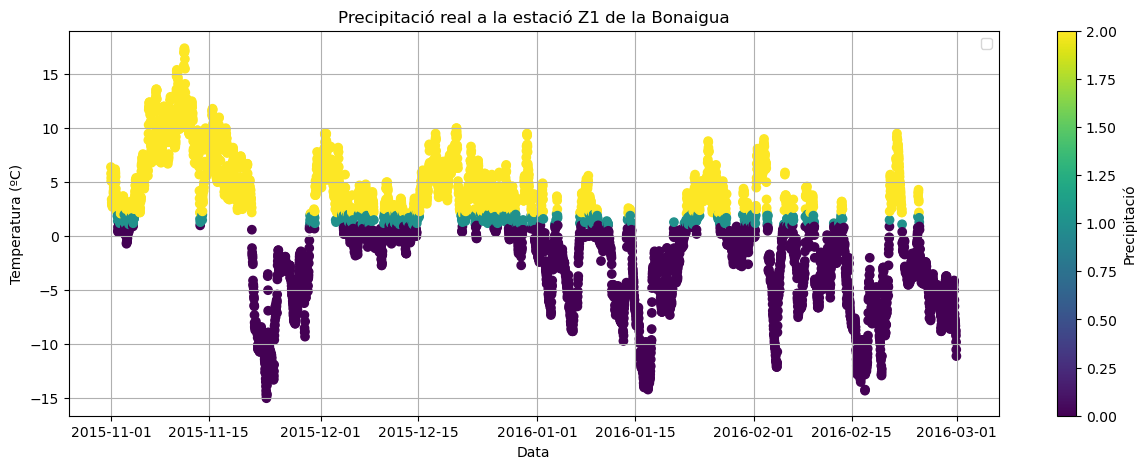

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


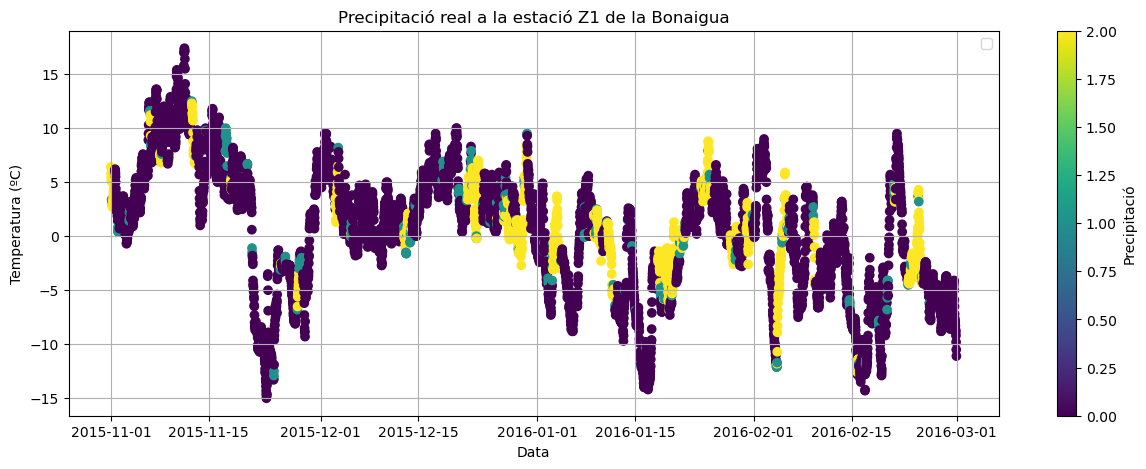

In [22]:
# Representem la precipitació real i la simulada en la temporada 2015-2016

plt.figure(figsize=(15, 5))

plt.scatter(df_hiverns_test['data'], df_hiverns_test['valor'], c=df_hiverns_test['precipitacio'].map({'N': 0, 'A': 1, 'P': 2}), cmap='viridis')

plt.title('Precipitació real a la estació Z1 de la Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.colorbar(label='Precipitació')

plt.grid()

plt.show()

# Representem la precipitació real i la simulada en la temporada 2015-2016

plt.figure(figsize=(15, 5))

plt.scatter(df_hiverns_test['data'], df_hiverns_test['valor'], c=df_hiverns_test['precip_simulada'].map({'N': 0, 'A': 1, 'P': 2}), cmap='viridis')

plt.title('Precipitació real a la estació Z1 de la Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.colorbar(label='Precipitació')

plt.grid()

plt.show()

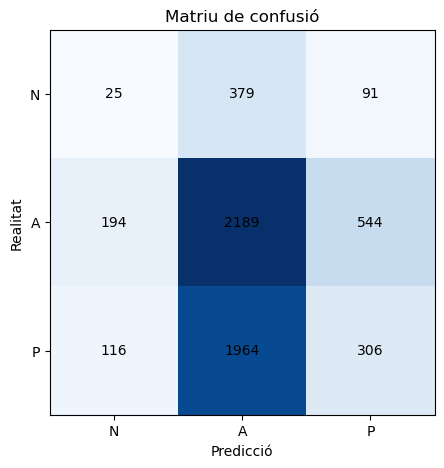

In [23]:
# Matriu de confusió

conf_matrix = confusion_matrix(df_hiverns_test['precipitacio'],df_hiverns_test['precip_simulada'])

plt.figure(figsize=(5, 5))
plt.imshow(conf_matrix, cmap='Blues')

plt.xticks([0, 1, 2], ['N', 'A', 'P'])
plt.yticks([0, 1, 2], ['N', 'A', 'P'])

plt.xlabel('Predicció')
plt.ylabel('Realitat')

plt.title('Matriu de confusió')

for i in range(3):
    for j in range(3):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.show()

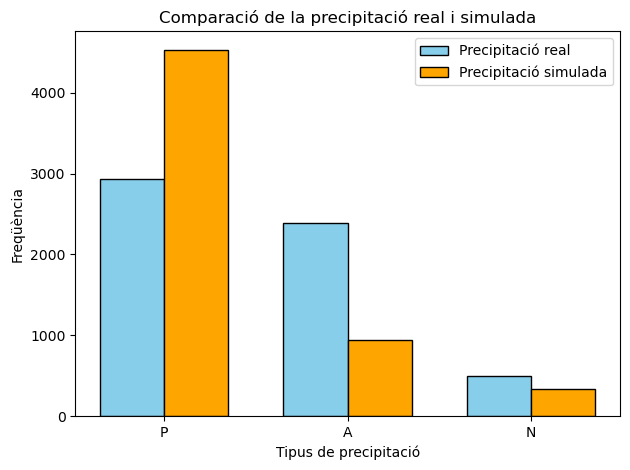

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Suposem que les sèries 'precipitacio' i 'precipitacio_simulada' estan agrupades per les categories "N", "A" i "P"
# A continuació, agrupem les dades per aquestes categories.

categories = df_hiverns_test['precipitacio'].unique()
# categories = ['N', 'A', 'P']
precip_real = df_hiverns_test['precipitacio'].value_counts() 
precip_simu = df_hiverns_test['precip_simulada'].value_counts()

# Ajustar l'amplada de les barres
width = 0.35

# Crear els índexs per a les categories
indices = np.arange(len(categories))

# Crear el gràfic de barres comparatives
plt.bar(indices - width/2, precip_real, width, label='Precipitació real', color='skyblue', edgecolor='black')
plt.bar(indices + width/2, precip_simu, width, label='Precipitació simulada', color='orange', edgecolor='black')

# Afegir títol i etiquetes
plt.title('Comparació de la precipitació real i simulada')
plt.xlabel('Tipus de precipitació')
plt.ylabel('Freqüència')
plt.xticks(indices, categories)  # Utilitzar les categories "N", "A", "P" com a etiquetes de l'eix X
plt.legend()  # Mostrar la llegenda

# Mostrar el gràfic
plt.tight_layout()  # Per evitar que les etiquetes es tallin
plt.show()


In [25]:
# Calcular accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Suposem que tens les etiquetes reals i les etiquetes predictes
y_true = df_hiverns_test['precipitacio']
y_pred = df_hiverns_test['precip_simulada']



# Calcular accuracy
accuracy = accuracy_score(y_true, y_pred)



# Mateix cas unificant hores cada 6

In [66]:
# De tot el Dataframe agafem les dades dels hiverns, es a dir els periodes de novembre a febrer inclosos

df_hiverns = df[
    (df['data'].dt.month >= 11) | (df['data'].dt.month <= 2)
]

# Resetejar els indexs o eliminar-los
df_hiverns = df_hiverns.reset_index(drop=True)

df_hiverns.head()

,data,valor
0,1998-01-01 00:00:00+00:00,-4.6
1,1998-01-01 01:00:00+00:00,-5.1
2,1998-01-01 02:00:00+00:00,-5.3
3,1998-01-01 03:00:00+00:00,-5.5
4,1998-01-01 04:00:00+00:00,-5.8


In [ ]:
# Fem el promig de la temperatura per cada 6h de cada dia. Es a dir. Promig de les temperatures dels intervals de 00:00 a 05:59, 06:00 a 11:59, 12:00 a 17:59 i 18:00 a 23:59

# Definim els intervals de temps

q1 = df_hiverns['data'].dt.hour < 6
q2 = (df_hiverns['data'].dt.hour >= 6) & (df_hiverns['data'].dt.hour < 12)
q3 = (df_hiverns['data'].dt.hour >= 12) & (df_hiverns['data'].dt.hour < 18)
q4 = (df_hiverns['data'].dt.hour >= 18) & (df_hiverns['data'].dt.hour <= 23)

for data in df_hiverns['data'].dt.date.unique():
    for i, q in enumerate([q1, q2, q3, q4]):
        df_hiverns.loc[(df_hiverns['data'].dt.date == data) & q, 'temperatura'] = df_hiverns.loc[(df_hiverns['data'].dt.date == data) & q, 'valor'].mean()



ValueError: Must have equal len keys and value when setting with an iterable

In [64]:

df_hiverns.head(48)

,data,valor,hora,dia
0,1998-01-01 00:00:00+00:00,-4.6,0,1998-01-01
1,1998-01-01 01:00:00+00:00,-5.1,1,1998-01-01
2,1998-01-01 02:00:00+00:00,-5.3,2,1998-01-01
3,1998-01-01 03:00:00+00:00,-5.5,3,1998-01-01
4,1998-01-01 04:00:00+00:00,-5.8,4,1998-01-01
5,1998-01-01 05:00:00+00:00,-6.0,5,1998-01-01
6,1998-01-01 06:00:00+00:00,-6.0,6,1998-01-01
7,1998-01-01 07:00:00+00:00,-6.0,7,1998-01-01
8,1998-01-01 08:00:00+00:00,-5.6,8,1998-01-01
9,1998-01-01 09:00:00+00:00,-4.6,9,1998-01-01


In [ ]:
# Unifiquem cada 6h les dades per tenir una freqüència de 6h. Fem el promig de temperatura de 6h en 6h i a partir d'aqui establim la variable de precipitació

# Els intervals horaris serien de 00:00 a 06:00, de 06:01 a 12:00, de 12:01 a 18:00 i de 18:01 a 23:59

# Creem un nou dataframe per fer-ho

df_hiverns_train_6h = df_hiverns_train.copy()

# Unifiquem les dades per cada 6h
df_hiverns_train_6h['data'] = df_hiverns_train_6h['data'].dt.floor('6H')


In [35]:
df_hiverns_train_6h.head()

,data,valor
196816,2014-11-01 00:00:00+00:00,6.5
196817,2014-11-01 00:30:00+00:00,6.4
196818,2014-11-01 01:00:00+00:00,6.5
196819,2014-11-01 01:30:00+00:00,6.4
196820,2014-11-01 02:00:00+00:00,6.2
